# Scrap & Crawl, avec Python

*par [Antoine Mazieres](https://www.antonomase.fr/) et [Julie Pierson](http://www.cnrs.fr/index.php/fr/personne/julie-pierson)*

Pendant cet atelier nous allons explorer diverses manières d'utiliser Python pour acquérir des données depuis des sources publiques.

L'idée est assez simple : si vous pouvez afficher des informations sur votre navigateur, il existe probablement la possibilité de l'acquérir à grande échelle et de manière structurée. Par exemple : vous êtes intéressé par les données d'un film disponibles sur le site [IMDb.com](https://www.imdb.com/) et voudriez pouvoir acquérir ces données pour des dizaines de milliers de films et les classer correctement dans une base de données.

Nous allons dans un premier temps apprendre à accéder à une page web avec python, puis à sélectionner dans celle-ci les données qui nous intéressent. Pour cela nous allons utiliser respectivement les bibliothèques [requests](https://requests.readthedocs.io/en/master/) et [lxml](https://lxml.de/). Cela recouvre des cas simples de ce que l'on appelle le [*web scraping*](https://en.wikipedia.org/wiki/Web_scraping).

Ensuite nous allons explorer des exemples de situations où il est nécessaire de découvrir et d'accéder à de nombreuses pages pour acquérir les données qui nous intéressent. Il s'agit alors de créer un [*crawler*](https://en.wikipedia.org/wiki/Web_crawler) ("robot d'indexation" en français).

## Accéder à une page web avec Python

In [1]:
import requests

In [2]:
# définir l'adresse de la page
url = "http://perdu.com/" # <- elle existe vraiment !

In [3]:
# assigner la page à une variable
page = requests.get(url)

In [4]:
# la variable "page" possède alors de nombreuses méthodes, 
# comme par exemple vérifier que la requête c'est bien passé (code 200) ...
page.status_code

200

In [5]:
# ... ou si la page n'existe pas (code 404)
requests.get("http://perdu.com/n-existe-pas").status_code

404

In [6]:
# Afficher le code source de la page
page.text

"<html><head><title>Vous Etes Perdu ?</title></head><body><h1>Perdu sur l'Internet ?</h1><h2>Pas de panique, on va vous aider</h2><strong><pre>    * <----- vous &ecirc;tes ici</pre></strong></body></html>\n"

## Parcourir la page et sélectionner des éléments

Le code source de la page est écrit en HTML. Vous pouvez voir le code source de n'importe quelle page que vous visitez en faisant un `clic droit` > `afficher le code source` dans votre navigateur. C'est le fait que ce langage soit structuré en balises (`<balise>`) et organise le contenu en arbre qui va nous permettre de récupérer ce qui nous intéresse. Formatés correctement, les balises font apparaître la structure en arbre du code source :

```
<html>
  <head>
    <title>Vous Etes Perdu ?</title>
  </head>
  <body>
    <h1>Perdu sur l'Internet ?</h1>
    <h2>Pas de panique, on va vous aider</h2>
    <strong>
      <pre>    * </pre>
    </strong>
  </body>
</html>
```

Pour se déplacer dans cet arbre, on utilise un langage de requête spécifique, appelé [`XPATH`](https://fr.wikipedia.org/wiki/XPath), qui permet de spécifier le lieu qui nous intéresse dans l'arborescence de la page.

In [7]:
# Importer la bibliothèque qui nous permettra d'analyser le code HTML de la page
from lxml import html

In [8]:
# Charger le contenu de la page dans une variable
tree = html.fromstring(page.text)

In [9]:
# On crée une requête xpath indiquant le chemin vers la balise <title>, 
# puis précisant qu'on veut le texte qu'elle contient
requete_xpath = '/html/head/title/text()'
tree.xpath(requete_xpath)

['Vous Etes Perdu ?']

In [10]:
# Comme il n'y a qu'une balise <title> dans cette page,
# on peut aussi faire une requête plus courte pour récupérer toutes les balises de ce nom,
# n'importe où sur la page. Pour ce faire, on commence la requête avec deux signes '/'
requete_xpath = '//title/text()'
tree.xpath(requete_xpath)

['Vous Etes Perdu ?']

**Une exemple plus réaliste**

Imaginons que nous voulions récupérer la liste des titres de sections d'une page Wikipedia, par exemple [la page à propos du site *perdu.com*](https://fr.wikipedia.org/wiki/Perdu.com). Il faut que l'on inspecte "à la main" le code source de la page. Pour ce faire on peut utiliser une fonction du navigateur : `clic droit` sur un élément de la page qui vous intéresse, puis `inspecter` (Chrome) / `examiner` (Firefox) `l'élément`. Comme le montre l'image ci-dessous, vous avez ainsi accès directement à la partie du code de la page qui vous intéresse.

![](https://www.antonomase.fr/img/wikipedia_inspect_code.png)

L'enjeu est maintenant de trouver un motif, ou une règle, qui permettra de construire une requête XPATH permettant d'identifier tous les titres de sections. Ici on voit que la balise `<span>` dans laquelle est contenu le titre de la section ("Description") possède un attribut de type `class` avec la valeur `mw-headline`. Cela laisse penser que cet élément pourrait être suffisant pour identifier les sections de la page. Pour formuler cette requête en XPATH, on utilisera les éléments suivants :

- `//` : n'importe où sur la page...
- `span` : ... séléctionner les balises "span"...
- `[@class="mw-headline"]` : ... qui possèdent la classe "mw-headline"...
- `/text()` : ... et extraire leur contenu.

`'//span[@class="mw-headline"]/text()'`

Il n'y a plus qu'à tester !

In [11]:
# Répétons les étapes précédentes jusqu'à obtenir l'arborescence de la page
url = "https://fr.wikipedia.org/wiki/Perdu.com"
page = requests.get(url)
tree = html.fromstring(page.text)

In [12]:
# Executons notre requête XPATH
tree.xpath('//span[@class="mw-headline"]/text()')

['Description',
 'Nombre de visiteurs et présence sur le web',
 'Notes et références',
 'Voir aussi',
 'Liens externes']

Ça marche !

Le langage de requête XPATH possède tout un tas de fonctions qui permettent de définir des motifs complexes pour identifier les éléments d'une page. Ce tutoriel vous permettra d'en explorer les principales : https://www.w3schools.com/xml/xpath_intro.asp

**EXERCICES**

**1.** Récupérez tous les liens sur la page qui pointent vers des pages Wikipedia.

In [38]:
# Code de votre réponse
def get_internal_links(url):
    page = requests.get(url)
    tree = html.fromstring(page.text)
    internal_links = set(tree.xpath("//a[starts-with(@href, '/wiki/')]/@href"))
    return list(internal_links)

internal_links = get_internal_links("https://fr.wikipedia.org/wiki/Perdu.com")
internal_links[:5]

['/wiki/1998_en_informatique',
 '/wiki/Aide:Accueil',
 '/wiki/Whois',
 '/wiki/Sp%C3%A9cial:Mes_discussions',
 '/wiki/Ast%C3%A9risque']

**2.** Créez un *crawler* qui aille faire la même procédure (récupérer les liens internes) sur cette liste de liens et sauvegardez ces données.

In [39]:
# Code de votre réponse
links = {}
for url in internal_links:
    new_internal_links = get_internal_links("https://fr.wikipedia.org" + url)
    links[url] = new_internal_links

**3.** Créez un graph avec [NetworkX](https://networkx.github.io/) (cf. atelier précédent) du réseau des liens entre toutes les pages que vous avez visitées.

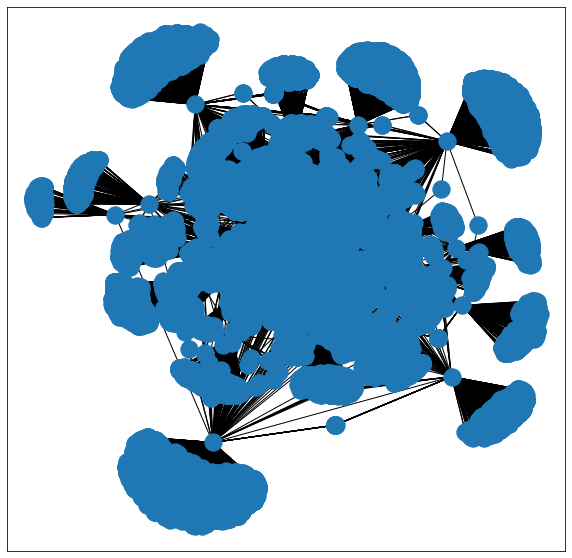

In [52]:
# Code de votre réponse
import networkx as nx
from matplotlib import pyplot as plt

G = nx.Graph()
for k, v in links.items():
    for url in v:
        G.add_edge(k.replace("/wiki/", ""), url.replace("/wiki/", ""))

fig, ax = plt.subplots(figsize=(10, 10))
nx.draw_networkx(G, with_labels=False)

*(Fascinant ! Une guerre nucléaire ou une rencontre de parachutistes ?)*

**4.** Pensez à un scénario que vous aimeriez explorer, soit pour récupérer des données, soit pour étudier la structure des liens entre les pages. Essayer de la réaliser ! 

In [16]:
# Code de votre réponse




